In [3]:
import cv2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

Checking for data imbalance 

In [ ]:
import os

list_ = os.listdir('/content/drive/MyDrive/cell_images_uz/cell_images/Uninfected') # dir is your directory path
number_files = len(list_)
print (number_files)

13780


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img = cv2.imread('/content/drive/MyDrive/cell_images_uz/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png')

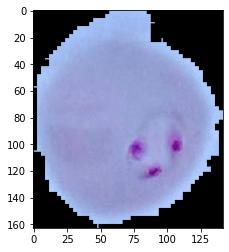

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
X = []
y = []

# uninfected = os.listdir('/content/drive/MyDrive/cell_images_uz/cell_images/Uninfected/') 
# parasitized = os.listdir('/content/drive/MyDrive/cell_images_uz/cell_images/Parasitized/')


uninfected = glob('/content/drive/MyDrive/cell_images_uz/cell_images/Uninfected/*.png') 
parasitized = glob('/content/drive/MyDrive/cell_images_uz/cell_images/Parasitized/*.png')

# for item in uninfected:
#     if item.endswith(".db"):
#         os.remove(item)

# for item in parasitized:
#     if item.endswith(".db"):
#         os.remove(item)

# for i in uninfected:
#   uninfected_img = cv2.imread("/content/drive/MyDrive/cell_images_uz/cell_images/Uninfected/"+i)
#   X.append(uninfected_img)
#   y.append(0)

# for k in parasitized:
#   parasitized_img = cv2.imread("/content/drive/MyDrive/cell_images_uz/cell_images/Parasitized/"+k)
#   X.append(parasitized_img)
#   y.append(0)

for i in uninfected:
  uninfected_img = cv2.imread(i)
  X.append(uninfected_img)
  y.append(0)

for k in parasitized:
  parasitized_img = cv2.imread(k)
  X.append(parasitized_img)
  y.append(0)



In [ ]:
print(len(X))

27558


In [ ]:
X_array = np.array(X)
y_array = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


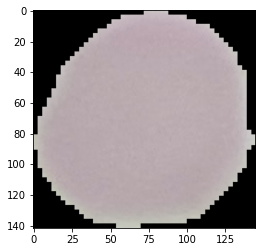

In [ ]:
new_img = X_array[1]
plt.imshow(new_img)
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/cell_images_uz/X_array.npy', X_array)

In [ ]:
np.save('/content/drive/MyDrive/cell_images_uz/y_array.npy', y_array)

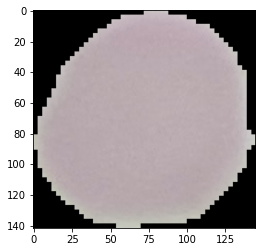

In [ ]:
new_img = X_array[1]
plt.imshow(new_img)
plt.show()

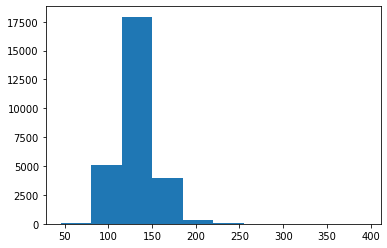

In [ ]:
height = []
width = []

for j in range(len(X_array)):

  height.append(X_array[j].shape[1])
  width.append(X_array[j].shape[0])
plt.hist(height)
plt.show()


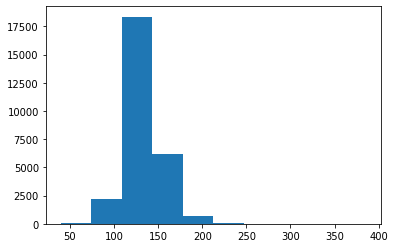

In [ ]:
plt.hist(width)
plt.show()

In [ ]:
new_img = y_array[999]
print(new_img)
# plt.imshow(new_img)
# plt.show()

0


In [ ]:
X_array[27559].shape[1]

142

In [ ]:
resized = []
for k in X_array:
  resized.append(cv2.resize(k, (50,50), interpolation=cv2.INTER_CUBIC))

checking if the image makes sense after resizing

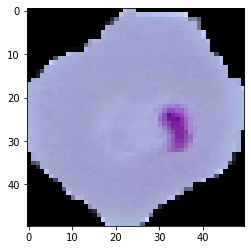

In [ ]:
new_resized = resized[20000]
plt.imshow(new_resized)
plt.show()

In [5]:
import os
os.remove("/content/drive/MyDrive/cell_images_uz/cell_images/Parasitized/Thumbs.db")
os.remove("/content/drive/MyDrive/cell_images_uz/cell_images/Uninfected/Thumbs.db")

FileNotFoundError: ignored

In [7]:
import tensorflow as tf

batch_size = 32
img_height = 50
img_width = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str('/content/drive/MyDrive/cell_images_uz/cell_images'),
  validation_split=0.2,
  subset="training",
  seed=50,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


NameError: ignored

In [9]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Parasitized' 'Uninfected']


In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
image_batch, labels_batch = next(iter(train_ds))

In [13]:
import tensorflow_hub as hub
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", input_shape=(50,50,3), trainable=False)

In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=20,
                    callbacks=[batch_stats_callback])

Epoch 1/20
689/689 [==============================] - 7723s 11s/step - loss: 0.2923 - acc: 0.9158
Epoch 2/20
689/689 [==============================] - 19s 27ms/step - loss: 0.2036 - acc: 0.9355
Epoch 3/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1914 - acc: 0.9392
Epoch 4/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1892 - acc: 0.9413
Epoch 5/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1896 - acc: 0.9416
Epoch 6/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1909 - acc: 0.9420
Epoch 7/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1894 - acc: 0.9452
Epoch 8/20
689/689 [==============================] - 19s 27ms/step - loss: 0.1852 - acc: 0.9471
Epoch 9/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1798 - acc: 0.9485
Epoch 10/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1757 - acc: 0.9487
Epoch 11/20
689/689 [=======

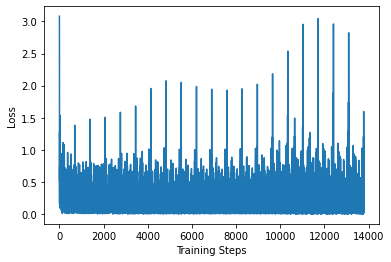

In [21]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
# plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

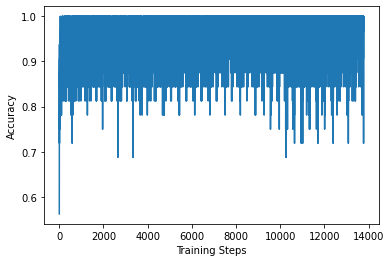

In [22]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
# plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [23]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

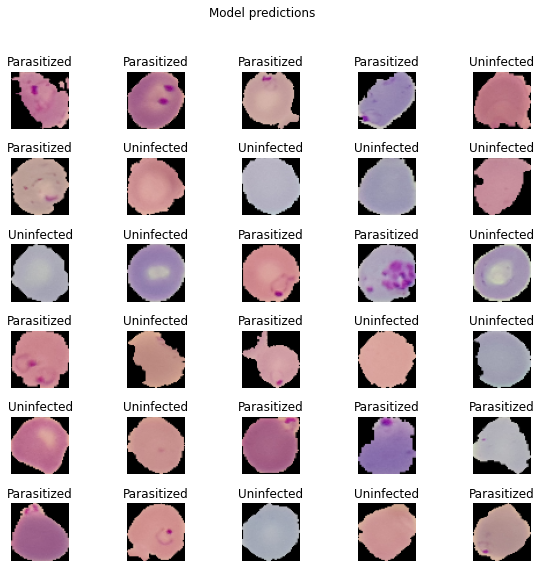

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")